### Team members

1. Amirhossein Soltani
2. Moein Taherkhani

In [77]:
import numpy as np
import os
import torch
import torch.nn as nn
import yaml
from pathlib import Path
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Downloading the dataset


In [78]:

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


### Dataset inspection

In [62]:
print(f"# Images Train: {len(train_dataset)}")
print(f"# Images Test:  {len(test_dataset)}")

# Images Train: 50000
# Images Test:  10000


In [63]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 32, 32])
Label: 6


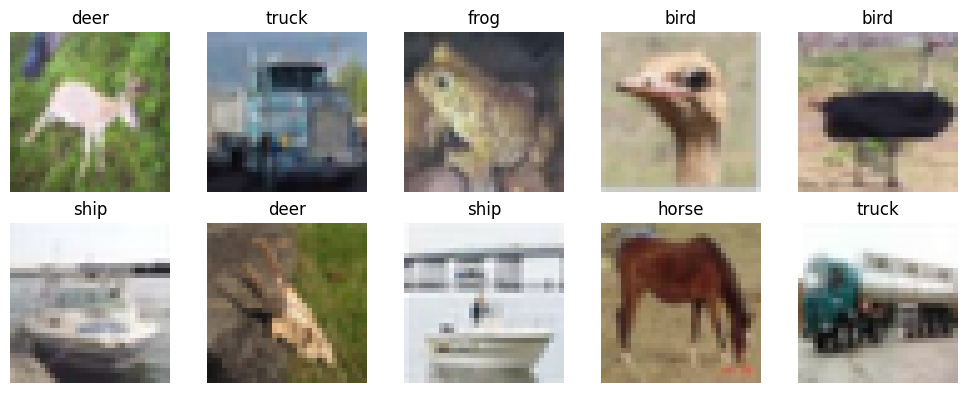

In [4]:
import matplotlib.pyplot as plt


classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

N_IMGS = 8
fig, ax = plt.subplots(2,5)
fig.set_size_inches(10, 4)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i in range(2):
    for j in range (5):
        id = np.random.randint(0,len(train_dataset),1)[0]
        img = train_dataset[id][0].numpy().transpose((1,2,0))
        ax[i,j].imshow(img)
        ax[i,j].set_title(f"{classes[train_dataset[id][1]]}")
        ax[i,j].axis("off")
plt.tight_layout()
plt.show()


### Training engines

In [81]:
log_dict = {'Training_loss' : [] ,'Validation_loss' : [] }

def trainer(model, criterion, optimizer, imgs, labels) -> float:
    model.train()

    # forward pass
    if model == mlp_model:
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = model(flattened_imgs)
    else:
        preds = model(imgs)

    loss = criterion(preds, labels)
    log_dict['Training_loss'].append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def validator(model, val_loader, criterion, epoch ) -> float:
    model.eval()
    val_loss = 0
    with torch.no_grad():
        print("##### Validating ... ####")

        for val_imgs, val_labels in val_loader:
            val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)

            if model == mlp_model:
                flattened_val_imgs = val_imgs.flatten(start_dim=1)
                val_preds = model(flattened_val_imgs)
            else: 
                val_preds = model(val_imgs)

            val_loss += criterion(val_preds, val_labels).item()
    
    avg_val_loss = val_loss / len(val_loader)
    log_dict['Validation_loss'].append(avg_val_loss)
    print(f"\nValidation loss after epoch {epoch + 1}: {avg_val_loss:.5f}\n")
    return avg_val_loss


### Training and Validation loop

In [89]:

def train(model : nn.Module, train_loader, val_loader, training_config):

    # Tensorboard log directory
    root = Path("./")
    log_dir = root/'log_dir'
    log_dir = os.path.join(log_dir, training_config['Experiment_name'])

    writer = SummaryWriter(log_dir=log_dir)  
    
    criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
    optimizer = torch.optim.Adam(model.parameters(), lr=training_config['lr'])

    ## Main training loop
    print("##### TRAINING ... ####")

    for epoch in range(training_config['epochs']):
        progress_bar = tqdm(train_loader, total=len(train_loader))

        for i, (imgs, labels) in enumerate(progress_bar):
            imgs, labels = imgs.to(device), labels.to(device)
            loss_tr = trainer(model= model, criterion=criterion, optimizer= optimizer, imgs= imgs, labels= labels)

            if(i % 5 == 0 or i == len(train_loader) - 1):
                progress_bar.set_description(f"Epoch {epoch + 1} Batch {i + 1}: loss {loss_tr:.5f}. ")
                
        # Validation every 10 epochs
        if (epoch + 1) % 10 == 0:
            avg_val_loss = validator(model = model, val_loader= val_loader, criterion= criterion, epoch = epoch)
            writer.add_scalar('Loss/val', avg_val_loss, epoch)

        writer.add_scalar('Loss/train', loss_tr, epoch)

    writer.close()


### EVALUATION

In [83]:
def evaluate (model : nn.Module, dataloader ):
    print("##### EVALUATION ... ####")
    model.eval()
    n_correct = 0

    with torch.no_grad():
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
        for i, (imgs, labels) in progress_bar: 
            imgs, labels = imgs.to(device), labels.to(device)

            if model == mlp_model:
                flattened_imgs = imgs.flatten(start_dim=1)
                preds = model(flattened_imgs)
            else:
                preds = model(imgs)

            pred_labels = torch.argmax(torch.softmax(preds, dim=-1), dim=-1)
            cur_correct = len(torch.where(pred_labels == labels)[0])
            n_correct = n_correct + cur_correct

    accuracy = n_correct / len(test_dataset) * 100
    print(f"Test accuracy: {round(accuracy,2)}%") 

### Saving the model

In [84]:
def save(model : nn.Module, training_config):
    root = Path("./")
    Experiment = training_config['Experiment_name']
    save_dir = root/'models'/Experiment

    if(not os.path.exists(save_dir)):
        os.makedirs(save_dir,exist_ok=True)
    # savepath = f"{root}/checkpoint_{training_config['Experiment_name']}.pth"

    checkpoint_path = os.path.join(save_dir,f"checkpoint_{training_config['Experiment_name']}.pth")
    torch.save({
                'model_state_dict': model.state_dict(),
                }, checkpoint_path)

    # Save the training configuration for each experiment
    with open(os.path.join(save_dir, "training_config.yaml"), "w") as f:
        yaml.dump(training_config, f)

### Dataloaders

In [85]:
training_config = {'BATCH_SIZE' : 1024,
                   'lr' : 1e-4,
                   'epochs' : 100,
                   'Experiment_name': 'Exp4'
                   }

Experiment = training_config['Experiment_name']

# Spliting the training dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=True
    )

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=training_config['BATCH_SIZE'],
    shuffle=False
)

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=False,
        drop_last=True
    )


## `MLP`

In [86]:
class Model(nn.Module):
    """
    MLP composed of two fully connected layers.
     - First layer takes pixel values and maps them to a hidden dimension
     - Nonlinear activation
     - Second layer maps from hidden dimension to number of classes, predicting a score for each of the classes
    """
    def __init__(self, input_dim=3072, hidden_dim=512, output_dim=len(classes)):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=output_dim)
            )
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred


In [87]:
mlp_model = Model().to(device)
summary(mlp_model, input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
              ReLU-4                  [-1, 512]               0
            Linear-5                   [-1, 10]           5,130
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 7.02
Estimated Total Size (MB): 7.05
----------------------------------------------------------------


In [ ]:
train(model= mlp_model, train_loader= train_loader, val_loader= val_loader, training_config= training_config)

In [91]:
evaluate(model= mlp_model, dataloader= eval_loader)

##### EVALUATION ... ####


100%|██████████| 9/9 [00:01<00:00,  7.55it/s]

Test accuracy: 28.2%


In [92]:
save(model = mlp_model, training_config= training_config)

### `CNN`

In [93]:
class CNNModel(nn.Module):

    ''' 
    Inspired by https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch
    '''
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, x):
        return self.network(x)

In [94]:
cnn_model = CNNModel().to(device)
summary(cnn_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
train(model= cnn_model, train_loader= train_loader, val_loader= val_loader, training_config= training_config)

In [ ]:
evaluate(model= cnn_model, dataloader= eval_loader)

In [97]:
save(model= cnn_model, training_config= training_config)